### Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from keras.wrappers.scikit_learn import KerasRegressor

from scipy.stats import norm, skew
from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

In [2]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5052419874228790943
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10879451877972537642
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [4]:
"""
print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
"""

"\nprint('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))\ntry:\n    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))\nexcept:\n    print('GPUs are not allocated. Current runtime is on CPU.')\n"

### Import data

In [130]:
data = pd.read_csv("data/data.csv")

In [4]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### Processing missing data & Drop unnecessary data

In [5]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

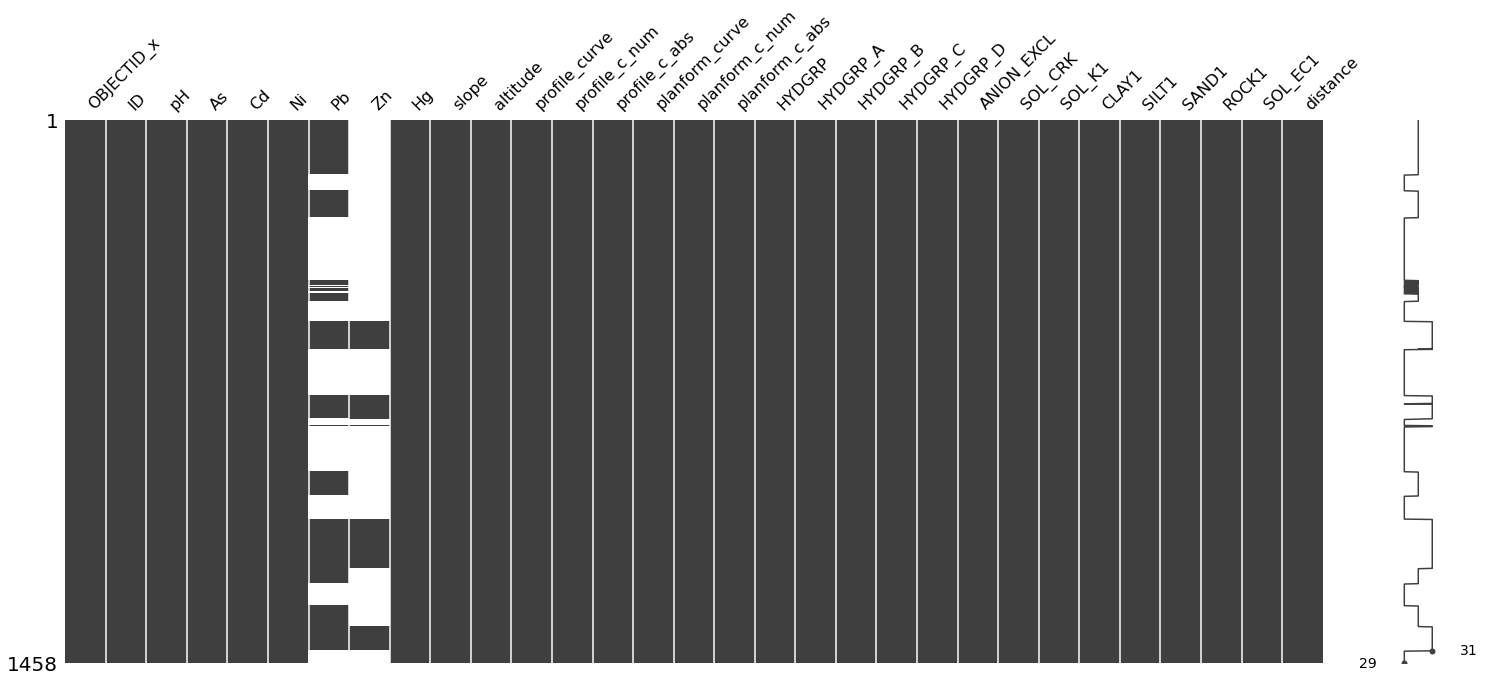

In [6]:
msno.matrix(data)

In [131]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [132]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [133]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [134]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [135]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

#### Log-Transformation

In [136]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

In [137]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

In [138]:
As_train_index = As_train.index
Cd_train_index = Cd_train.index
Ni_train_index = Ni_train.index

#### Scaling

In [139]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [140]:
scaler = StandardScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)


#### Define Hyperparameter

In [17]:
# dense_nparams_n : n-dense layer size
dense_nparams_1 = [64, 256]
dense_nparams_2 = [512, 2048]
dense_nparams_3 = [64, 256]

"""# dense_layer_sizes : dense layer size list
dense_layer_sizes = [(64, 512, 64, ), (256, 2048, 256, )]"""

"""# input_optimizer : using optimizer
input_optimizer = [SGD, Adagrad, RMSprop, Adam, Adamax]"""

"""# input_kernel_initializer : to initialize weights
input_kernel_initializer = ['uniform', 'normal', 
                            'glorot_uniform', 'glorot_normal',
                            'he_uniform', 'he_normal' ]"""

"""# kernel_regularizer_weight_decay : regularizer weight decay list
kernel_regularizer_weight_decay = [0.01, 0.001, 0.0001]"""


"""# input_dropout : dropout ratio
input_dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]"""

# input_lr : learning_rate
input_lr = [0.1, 0.01, 0.001]

# batch_size : batch_size
batch_size = [64, 128, 256]

# epochs : epochs
epochs = [50, 100]

# optimizers: optimizers
optimizers = [Adam, RMSprop]

# hyperparameter dict
param_grid = dict(dense_nparams_1 = dense_nparams_1,
                  dense_nparams_2 = dense_nparams_2,
                  dense_nparams_3 = dense_nparams_3,
                  input_lr = input_lr)

val_param_grid = dict(batch_size = batch_size,
                    epochs = epochs,
                    optimizers = optimizers)

# Bayesian hyperparmeter dict
bay_pbounds = {
    'dense_nparams' : (64, 256),
    'dense_layer_sizes' : (64, 256),
    'input_dropout' : (0.01, 0.05),
    'kernel_regularizer_weight_decay' : (0.001, 0.1),
    'input_lr' : (0.001, 0.1)
}

#### GridSearchCV & Bayesian optimization

In [24]:
# RMSE custom metric

def rmse(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    return rmse

### Optuna Optimization

In [16]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [17]:
def objectiveDNN(trial: Trial, X_train, y_train) -> float:
    
    n_layers = trial.suggest_int('n_layers', 2, 5)
    dense_param = trial.suggest_int('dense_param', 64, 256)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 0.1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 128, 256, 64))
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(dense_param, activation='relu',
                                    input_shape = (train.shape[1],), 
                                    kernel_regularizer = keras.regularizers.l2(weight_decay)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.BatchNormalization())
    
    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(dense_param, activation='relu',
                                        kernel_regularizer = keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(1))
          
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), 
                  loss='mse', metrics=['mse'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=30, restore_best_weights=True)

    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                     patience=10, verbose=0, mode='auto', 
                                                     min_delta=0.0001, cooldown=0, min_lr=0)
    
    history = model.fit(X_train, y_train, validation_split=0.1, 
                        epochs=1000, batch_size=batch_size, callbacks=[early_stopping, lr_scheduler], 
                        verbose=0)
    
    return 1 - history.history['val_loss'][-1]

In [39]:
study = optuna.create_study(
    study_name="dnn_parameter_opt",
    direction = 'minimize'
)

study.optimize(lambda trial : objectiveDNN(trial, As_X, As_y), n_trials=50)
print("Best rmse Score: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-09-12 14:52:03,027] A new study created in memory with name: dnn_parameter_opt
[I 2022-09-12 14:52:25,094] Trial 0 finished with value: 0.8148166984319687 and parameters: {'n_layers': 4, 'dense_param': 114, 'weight_decay': 0.07279184748281999, 'batch_size': 128.0}. Best is trial 0 with value: 0.8148166984319687.
[I 2022-09-12 14:52:42,718] Trial 1 finished with value: 0.8097092807292938 and parameters: {'n_layers': 3, 'dense_param': 142, 'weight_decay': 0.06040026127155611, 'batch_size': 128.0}. Best is trial 1 with value: 0.8097092807292938.
[I 2022-09-12 14:52:58,878] Trial 2 finished with value: 0.7962759137153625 and parameters: {'n_layers': 3, 'dense_param': 189, 'weight_decay': 0.09421348556453957, 'batch_size': 256.0}. Best is trial 2 with value: 0.7962759137153625.
[I 2022-09-12 14:53:15,152] Trial 3 finished with value: 0.7916507571935654 and parameters: {'n_layers': 3, 'dense_param': 254, 'weight_decay': 0.08158499118494264, 'batch_size': 192.0}. Best is trial 3 with 

Best rmse Score:  0.7495264112949371
Best trial: {'n_layers': 3, 'dense_param': 179, 'weight_decay': 0.0015884603236689587, 'batch_size': 192.0}


In [40]:
optuna.visualization.plot_param_importances(study)

### DNN model

#### 10-Fold Crossvalidation

In [141]:
kf = KFold(n_splits = 10, random_state = 605, shuffle = True)

#### Custom Metrics

In [142]:
def r_2_score(y_true, y_pred):
    SSR = K.sum(K.square(y_true - y_pred))
    SSE = K.sum(K.square(y_pred - K.mean(y_true)))
    # SST = K.sum(K.square(y_true - K.mean(y_true)))
    SST = SSE+SSR
    
    return SSE/SST

In [143]:
def AsDNN(test, X, y):
    weight_decay = 0.0001
    eta = 0.001
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=50, restore_best_weights=True)

    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                     patience=10, verbose=0, mode='auto', 
                                                     min_delta=0.0001, cooldown=0, min_lr=0)
    
    pred = np.zeros((test.shape[0], 10))
    
    train_rmse_list = []
    val_rmse_list = []
    train_r2_list = []
    val_r2_list = []

    # structure :
    
    for i, (tr_idx, val_idx) in enumerate(kf.split(X, y)) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
        
        model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(tr_x.shape[1],), 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)])
        
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=eta), 
                      loss='mse', metrics=[r_2_score])
        
        As_history = model.fit(tr_x, tr_y, epochs=1200, validation_data = (val_x, val_y),
                               batch_size=128, verbose=1)
        
        train_rmse = min(As_history.history['loss'])**0.5
        train_rmse_list.append(train_rmse)
        val_rmse = min(As_history.history['val_loss'])**0.5
        val_rmse_list.append(val_rmse)
        
        train_r2 = max(As_history.history['r_2_score'])
        train_r2_list.append(train_r2)
        val_r2 = max(As_history.history['val_r_2_score'])
        val_r2_list.append(val_r2)
        
        # reverse log scailing & predict
        As_pred = model.predict(test)

        As_pred = np.expm1(As_pred) / 10
        pred += As_pred
        
        print(f'{i + 1}번째 학습 FOLD 학습 완료\n')
        
    print(f'Train AsDNN의 10fold RMSE는 {train_rmse_list}')
    print(f'Train AsDNN의 10fold R2는 {train_r2_list}')
    print(f'Train AsDNN의 10fold 평균 RMSE는 {np.mean(train_rmse_list)}')
    print(f'Train AsDNN의 10fold 평균 R2는 {np.mean(train_r2_list)}\n\n')
        
    print(f'Validation AsDNN의 10fold RMSE는 {val_rmse_list}')
    print(f'Validation AsDNN의 10fold R2는 {val_r2_list}')
    print(f'Validation AsDNN의 10fold 평균 RMSE는 {np.mean(val_rmse_list)}')
    print(f'Validation AsDNN의 10fold 평균 R2는 {np.mean(val_r2_list)}')
        
    return pred

In [144]:
dnn_pred = AsDNN(As_test, As_X, As_y)

Epoch 1/1200
8/8 [==============================] - 2s 62ms/step - loss: 1.2899 - r_2_score: 0.4709 - val_loss: 0.4564 - val_r_2_score: 0.3915
Epoch 2/1200
8/8 [==============================] - 0s 42ms/step - loss: 1.0120 - r_2_score: 0.4685 - val_loss: 0.4832 - val_r_2_score: 0.4010
Epoch 3/1200
8/8 [==============================] - 0s 39ms/step - loss: 0.9110 - r_2_score: 0.4424 - val_loss: 0.4577 - val_r_2_score: 0.3922
Epoch 4/1200
8/8 [==============================] - 0s 39ms/step - loss: 0.8020 - r_2_score: 0.4601 - val_loss: 0.4106 - val_r_2_score: 0.3727
Epoch 5/1200
8/8 [==============================] - 0s 39ms/step - loss: 0.7976 - r_2_score: 0.4458 - val_loss: 0.3894 - val_r_2_score: 0.3654
Epoch 6/1200
8/8 [==============================] - ETA: 0s - loss: 0.6352 - r_2_score: 0.449 - 0s 38ms/step - loss: 0.6329 - r_2_score: 0.4488 - val_loss: 0.3884 - val_r_2_score: 0.3640
Epoch 7/1200
8/8 [==============================] - 0s 39ms/step - loss: 0.7254 - r_2_score: 0.435

In [145]:
As_dnn_pred = np.zeros((As_test.shape[0]))

for i, (value) in enumerate(dnn_pred):
    As_dnn_pred[i] = value[0]

# -----------------------------

In [80]:
def simpleDNN(train):
    weight_decay = 0.0001
    learning_rate = 0.001

    # structure :
    
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(train.shape[1],), 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    
    return model, learning_rate

#### AS

In [81]:
model, eta = simpleDNN(As_X)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=eta), 
              loss='mse', metrics=[r_2_score])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=50, restore_best_weights=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [82]:
As_history = model.fit(As_X, As_y, validation_split=0.1, 
                        epochs=2, batch_size=128, verbose=1)

"""As_history = model.fit(As_X, As_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, verbose=1)"""

Epoch 1/2
8/8 [==============================] - 2s 64ms/step - loss: 1.0630 - r_2_score: 0.4880 - val_loss: 0.6623 - val_r_2_score: 0.4094
Epoch 2/2
8/8 [==============================] - 0s 39ms/step - loss: 0.9001 - r_2_score: 0.4602 - val_loss: 0.6169 - val_r_2_score: 0.4026


'As_history = model.fit(As_X, As_y, validation_split=0.1, \n                        epochs=1000, batch_size=256, verbose=1)'

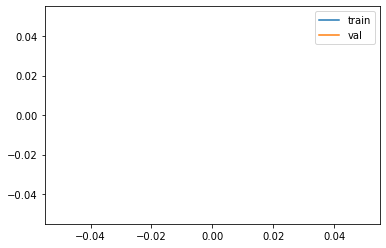

IndexError: list index out of range

In [83]:
plt.plot(As_history.history['loss'][3:], label='train')
plt.plot(As_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(As_history.history['val_loss'][-30])

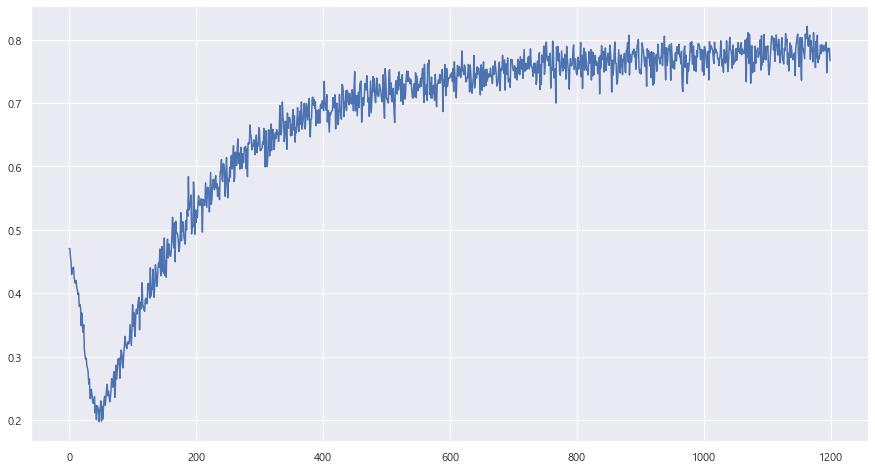

In [440]:
plt.plot(As_history.history['r_2_score'])

In [84]:
# predict
As_pred = model.predict(As_test)

# reverse log scailing
As_pred = np.expm1(As_pred)

#### Cd

In [382]:
model, eta = simpleDNN(Cd_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=[r_2_score])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=50, restore_best_weights=True)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [384]:
Cd_history = model.fit(Cd_X, Cd_y, validation_split=0.1, 
                        epochs=2000, batch_size=256, verbose=1)

Epoch 1/2000
4/4 [==============================] - 0s 31ms/step - loss: 0.0030 - r_2_score: 0.6046 - val_loss: 0.0046 - val_r_2_score: 0.2971
Epoch 2/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.0029 - r_2_score: 0.6199 - val_loss: 0.0048 - val_r_2_score: 0.3171
Epoch 3/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.0029 - r_2_score: 0.6298 - val_loss: 0.0049 - val_r_2_score: 0.3021
Epoch 4/2000
4/4 [==============================] - 0s 16ms/step - loss: 0.0029 - r_2_score: 0.6446 - val_loss: 0.0050 - val_r_2_score: 0.2931
Epoch 5/2000
4/4 [==============================] - 0s 17ms/step - loss: 0.0029 - r_2_score: 0.6199 - val_loss: 0.0049 - val_r_2_score: 0.2757
Epoch 6/2000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - r_2_score: 0.5918 - val_loss: 0.0050 - val_r_2_score: 0.2812
Epoch 7/2000
4/4 [==============================] - 0s 16ms/step - loss: 0.0029 - r_2_score: 0.6286 - val_loss: 0.0051 - val_r_2_score: 0.3051

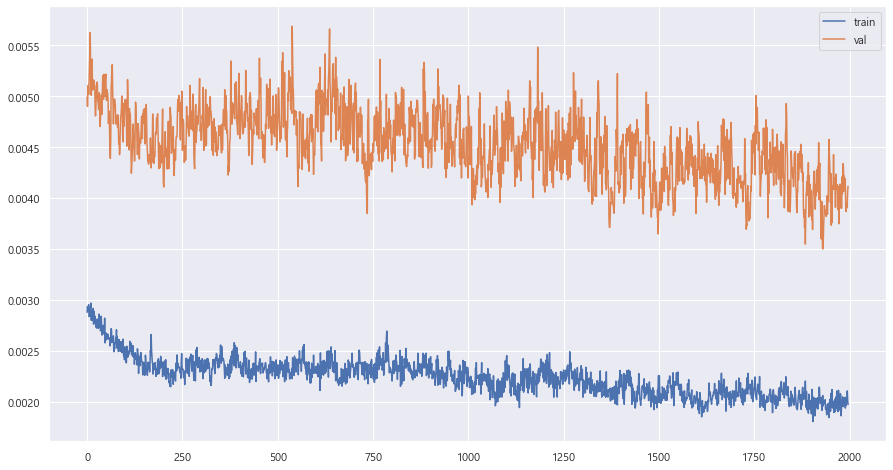

0.004093825817108154


In [385]:
plt.plot(Cd_history.history['loss'][3:], label='train')
plt.plot(Cd_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Cd_history.history['val_loss'][-30])

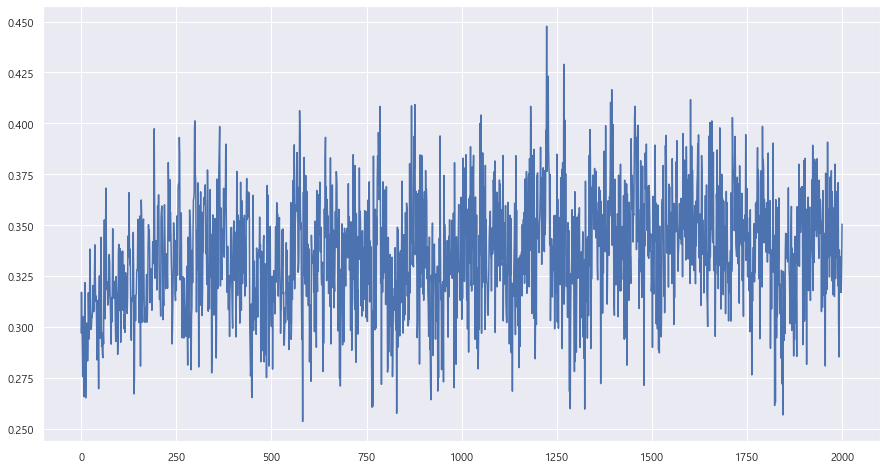

In [392]:
plt.plot(Cd_history.history['val_r_2_score'])

In [386]:
# predict
Cd_pred = model.predict(Cd_test)

# reverse log scailing
Cd_pred = np.expm1(Cd_pred)

#### Ni

In [255]:
model, eta = simpleDNN(Ni_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=[r_2_score])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=50, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [256]:
Ni_history = model.fit(Ni_X, Ni_y, validation_split=0.1, 
                        epochs=1500, batch_size=256, callbacks=[early_stopping], verbose=1)

Epoch 1/1500
4/4 [==============================] - 1s 74ms/step - loss: 17.6090 - r_2_score: 0.4436 - val_loss: 15.3035 - val_r_2_score: 0.4178
Epoch 2/1500
4/4 [==============================] - 0s 19ms/step - loss: 16.6759 - r_2_score: 0.4555 - val_loss: 14.9983 - val_r_2_score: 0.4127
Epoch 3/1500
4/4 [==============================] - 0s 21ms/step - loss: 15.8971 - r_2_score: 0.4593 - val_loss: 14.7409 - val_r_2_score: 0.4075
Epoch 4/1500
4/4 [==============================] - 0s 21ms/step - loss: 15.4536 - r_2_score: 0.4397 - val_loss: 14.4753 - val_r_2_score: 0.4015
Epoch 5/1500
4/4 [==============================] - 0s 20ms/step - loss: 14.9306 - r_2_score: 0.4424 - val_loss: 14.2165 - val_r_2_score: 0.3952
Epoch 6/1500
4/4 [==============================] - 0s 20ms/step - loss: 14.6672 - r_2_score: 0.4343 - val_loss: 14.0280 - val_r_2_score: 0.3907
Epoch 7/1500
4/4 [==============================] - 0s 20ms/step - loss: 14.4965 - r_2_score: 0.4287 - val_loss: 13.8705 - val_r_2

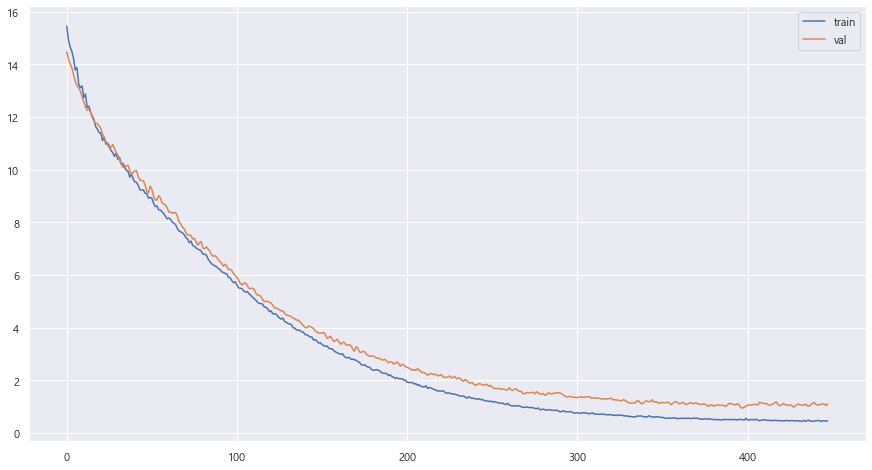

1.0609220266342163


In [257]:
plt.plot(Ni_history.history['loss'][3:], label='train')
plt.plot(Ni_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Ni_history.history['val_loss'][-30])

In [258]:
# test predict
Ni_pred = model.predict(Ni_test)

# reverse log scailing
Ni_pred = np.expm1(Ni_pred)

### Evaluate Model

In [146]:
As_test = pd.DataFrame()
Cd_test = pd.DataFrame()
Ni_test = pd.DataFrame()

As_test['index'] = As_test_index
Cd_test['index'] = Cd_test_index
Ni_test['index'] = Ni_test_index

for index in As_test['index']:
    As_test.loc[As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    
for index in Cd_test['index']:
    Cd_test.loc[Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']

for index in Ni_test['index']:
    Ni_test.loc[As_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [148]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(pred)):
        sst += ((data[i] - np.mean(data))**2)
        
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(pred)):
        sse += ((pred[i] - np.mean(data))**2)
        
    return sse

def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += ((data[i] - pred[i])**2)
    
    return ssr

#### r2 scoring

In [149]:
def cal_train_r2(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred


    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    # sst = sse + ssr
    sst = SST(test['real_value'], test['value'])
    
    test_r2 = sse/sst
    print(f'r2 score : {test_r2}')

In [150]:
cal_train_r2(As_dnn_pred, As_test['As_real_value'])
#cal_train_r2(Cd_pred, Cd_test['Cd_real_value'])
#cal_train_r2(Ni_pred, Ni_test['Ni_real_value'])

r2 score : 0.7280441107197805


#### rmse scoring

In [387]:
def cal_rmse(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred

    rmse = np.sqrt(mean_squared_error(test['real_value'], test['value']))
    print(f'rmse : {rmse}')

In [444]:
cal_rmse(As_pred, As_test['As_real_value'])
cal_rmse(Cd_pred, Cd_test['Cd_real_value'])
cal_rmse(Ni_pred, Ni_test['Ni_real_value'])

rmse : 0.9207731637088123
rmse : 0.06795311958657047
rmse : 7.217983275934148


### Visualization

In [97]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,14)},
        style='darkgrid',
       )

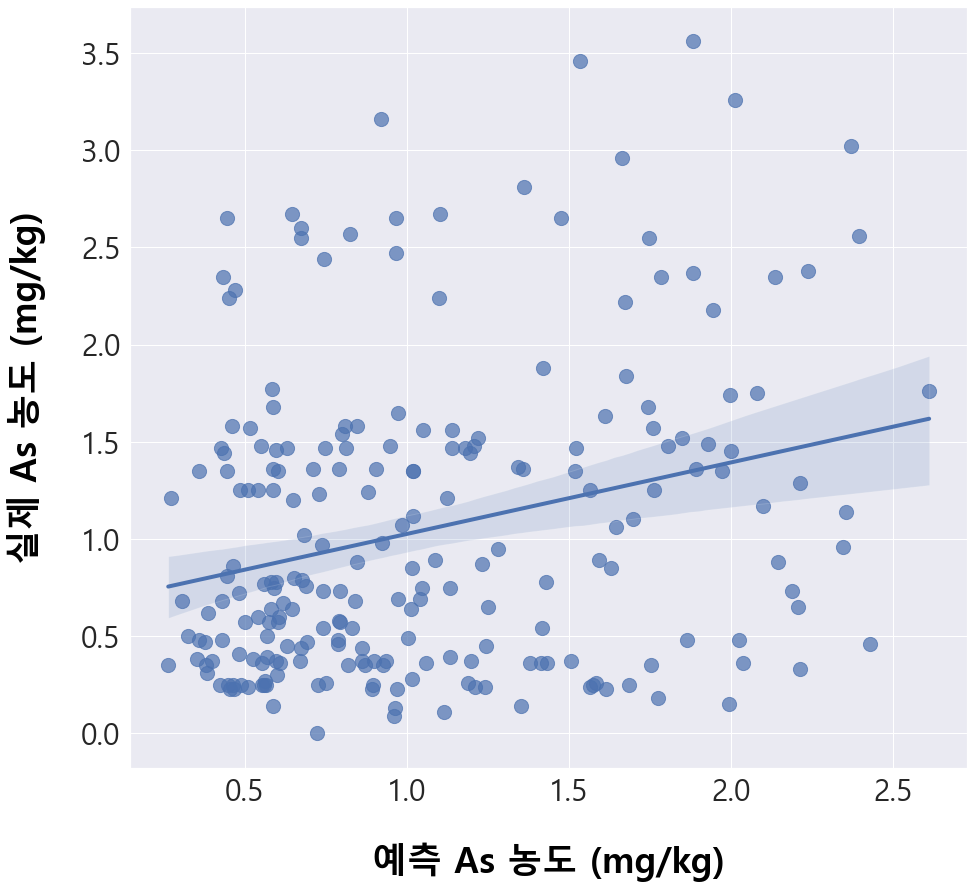

In [102]:
#plt.title('DNN을 이용하여 예측한 As의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
#plt.scatter(As_pred, As_test['As_real_value'], marker='D', alpha=0.5)
sns.regplot(As_pred, As_test['As_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

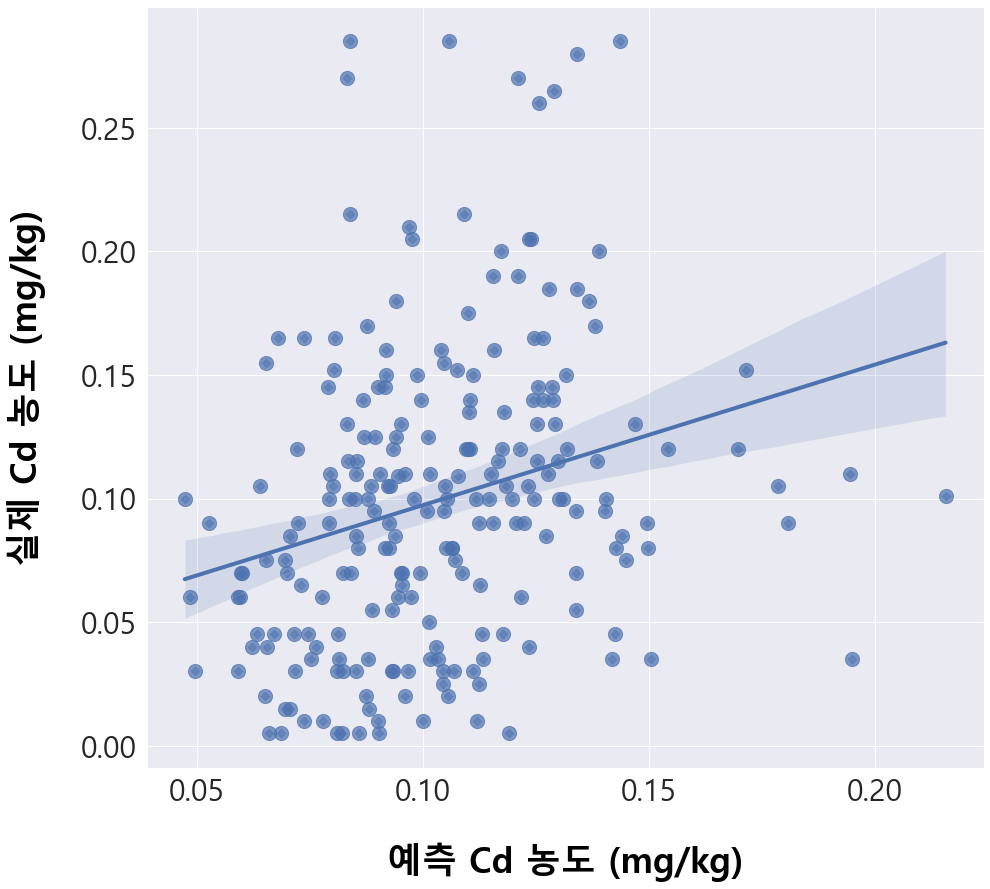

In [108]:
#plt.title('DNN을 이용하여 예측한 Cd의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], fontsize = 30)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize = 30)
plt.scatter(Cd_pred, Cd_test['Cd_real_value'], marker='D', alpha=0.5)
sns.regplot(Cd_pred, Cd_test['Cd_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

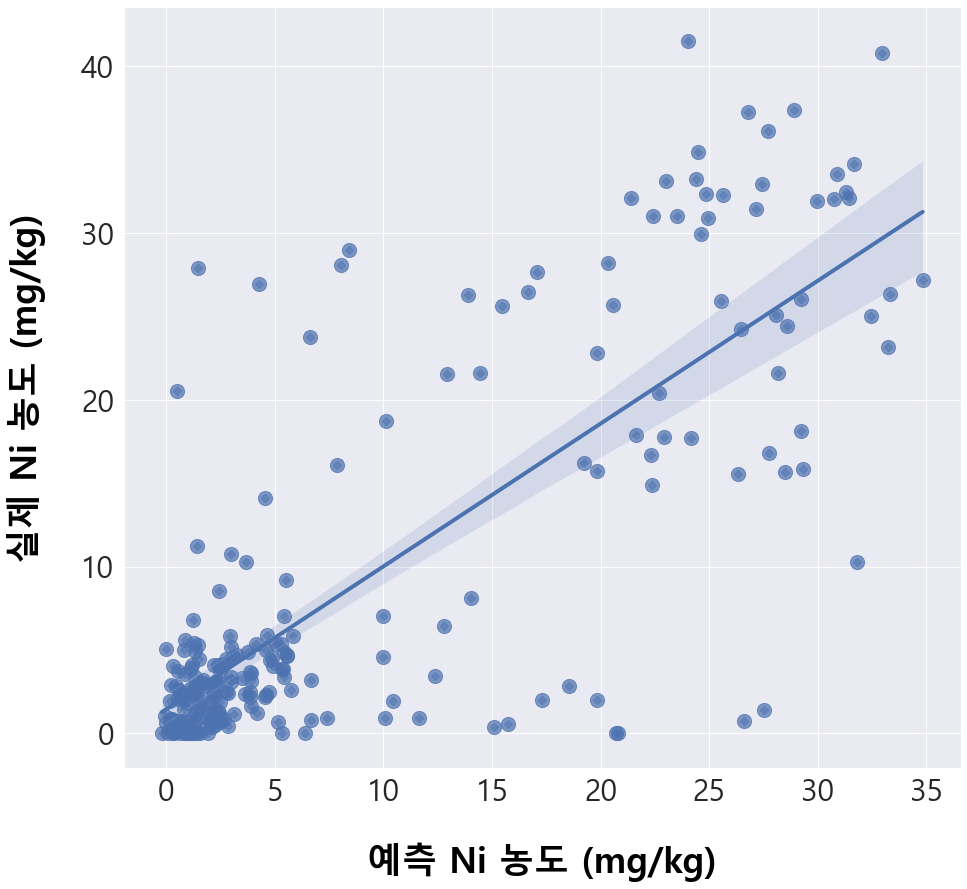

In [104]:
#plt.title('DNN을 이용하여 예측한 Ni의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.scatter(Ni_pred, Ni_test['Ni_real_value'], marker='D', alpha=0.5)
sns.regplot(Ni_pred, Ni_test['Ni_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()